## Camera calibration and undistortion

Calibrate the camera using provided images in `camera_cal` directory.
Pickup a single image in the `camera_cal` directory and see undistortion works well.

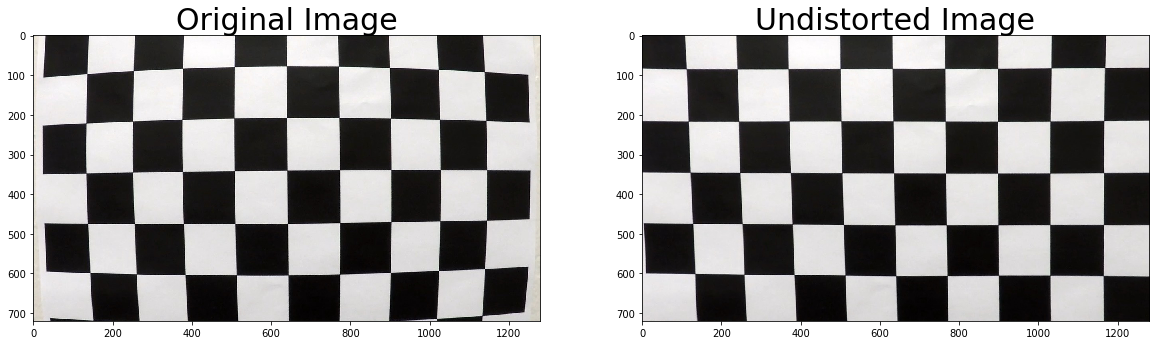

In [221]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pickle

import matplotlib.image as mpimg
%matplotlib inline

nx = 9
ny = 5

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,4,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration1*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

        
# Save mtx, dist
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./calibration_result/calibration_result_pickle.p", "wb" ) )

# Check result with a single image.
sample = mpimg.imread('./camera_cal/calibration1.jpg')
sample_undist = cv2.undistort(sample, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(sample_undist)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply undistortion to test images

Apply undistortion with the calibration parameters obtained in previous steps.
After the undistortion, choose four coners to execute perspective transform.

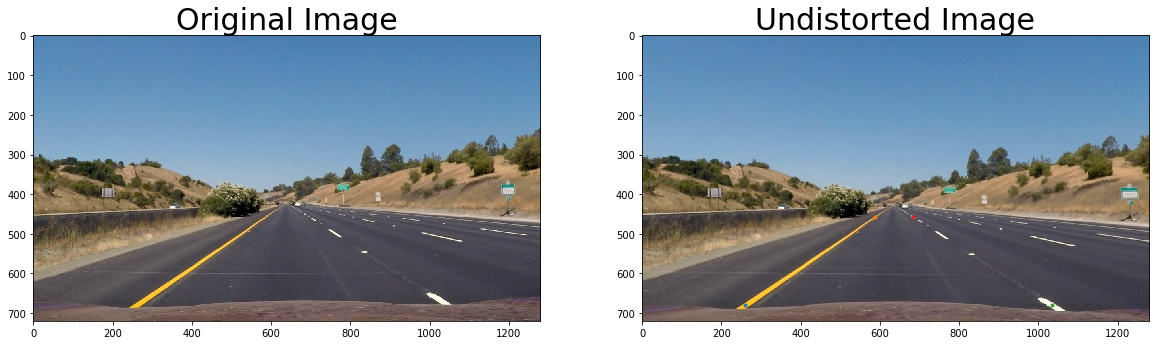

In [284]:
img = mpimg.imread('./test_images/straight_lines1.jpg')

c_result = pickle.load(open('calibration_result/calibration_result_pickle.p','rb'))
mtx = c_result['mtx']
dist = c_result['dist']

undist = cv2.undistort(img, mtx, dist, None, mtx)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

#mpimg.imsave('./output_images/undist_straight_lines1.jpg', undist)

src_bottom_left = [261.0, 680.0]
src_upper_left = [588.0, 457.0]
src_bottom_right = [1034.0, 680.0]
src_upper_right = [684.0, 457.0]
ax2.plot(src_bottom_left[0], src_bottom_left[1], '.')
ax2.plot(src_upper_left[0], src_upper_left[1], '.')
ax2.plot(src_bottom_right[0], src_bottom_right[1], '.')
ax2.plot(src_upper_right[0], src_upper_right[1], '.')

## Test perspective transform
Execute perspective transform.

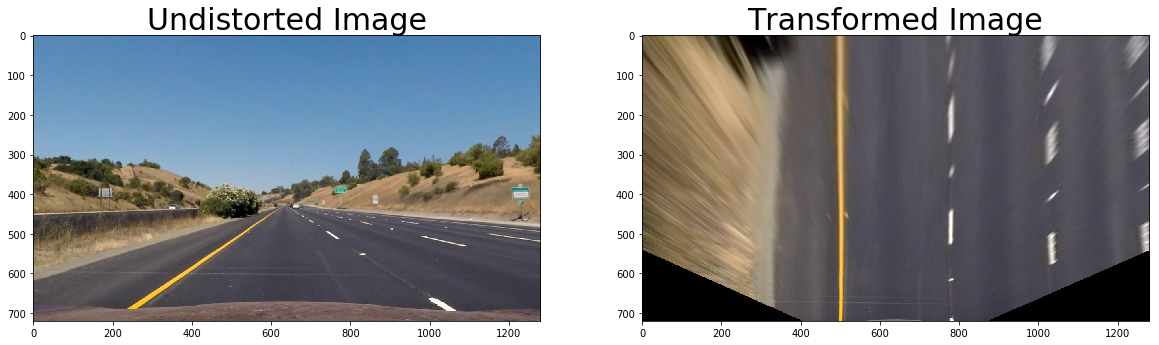

In [285]:
src = np.float32([
    src_bottom_left,
    src_upper_left,
    src_bottom_right,
    src_upper_right
])

dst_bottom_left = [500, 720]
dst_upper_left = [500,0]
dst_bottom_right = [780, 720]
dst_upper_right = [780, 0]
dst = np.float32([
    dst_bottom_left,
    dst_upper_left,
    dst_bottom_right,
    dst_upper_right
])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (undist.shape[1], undist.shape[0])
warped = cv2.warpPerspective(undist, M, img_size)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Transformed Image', fontsize=30)

In [74]:
def undist_image(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

In [75]:
def prepare_image(image):
    undist = undist_image(image)
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped

## Apply undistortion/ perspective transfrom to all test images.

Apply undistortion, perspective transfrom to all test images provided in `test_images` directory.

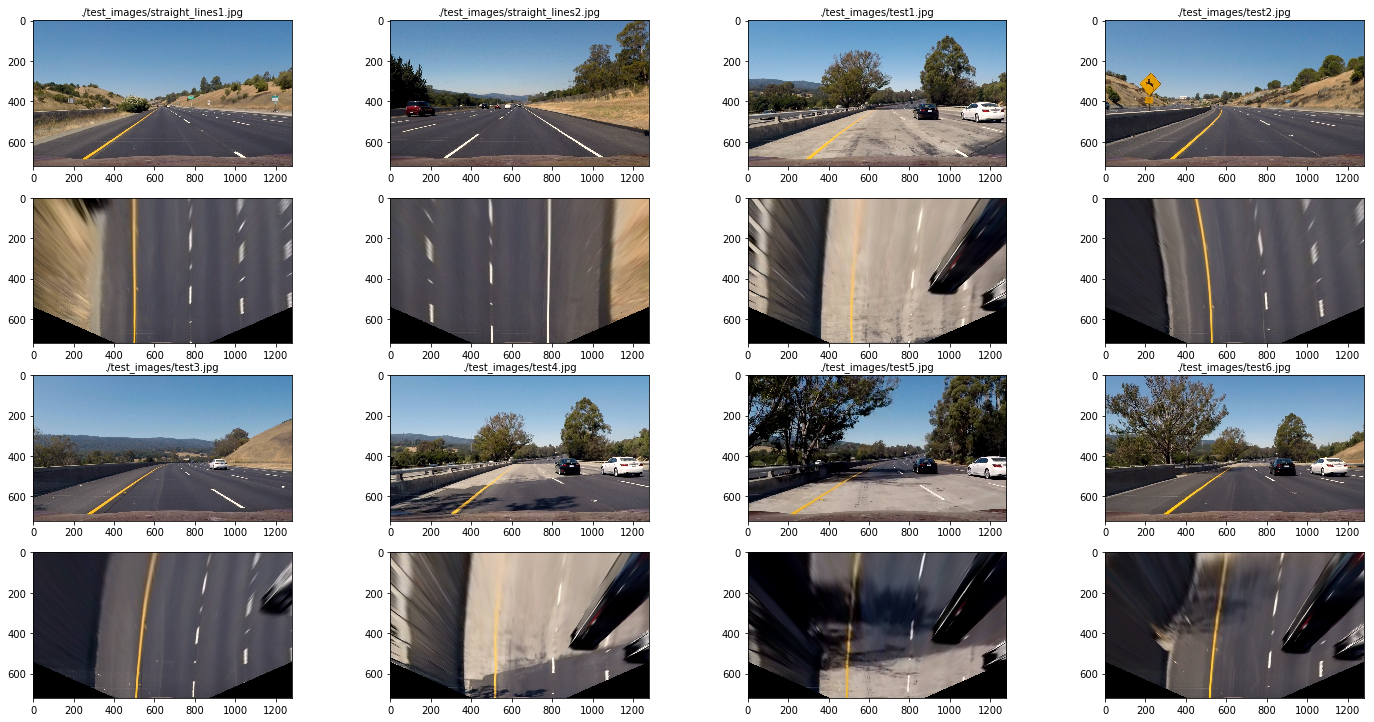

In [68]:
test_images = glob.glob('./test_images/*.jpg')

f, subs = plt.subplots(4, 4, figsize=(20,10))
plt.tight_layout()
for idx, fname in enumerate(test_images):
#    image = cv2.imread(fname)
    image = mpimg.imread(fname)
    warped = prepare_image(image)
    if 0 <= idx and idx <= 3:
        subOrig = subs[0][idx]
        sub = subs[1][idx]
    else:
        subOrig = subs[2][idx%4]
        sub = subs[3][idx%4]
    sub.imshow(warped)
    subOrig.set_title(fname, fontsize=10)
    subOrig.imshow(image)

## Create thresholded binary image.

In [143]:
def convert_color(img, s_thresh=(100, 245), sx_thresh=(130, 255), dark_thresh=50):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=31) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    (R,G,B) = cv2.split(img)
    s_binary[(R<dark_thresh) & (G<dark_thresh) & (B<dark_thresh)] = 0

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    # Remove side images
    combined_binary[:, 0:280] = 0
    combined_binary[:, 1000:] = 0

    return combined_binary

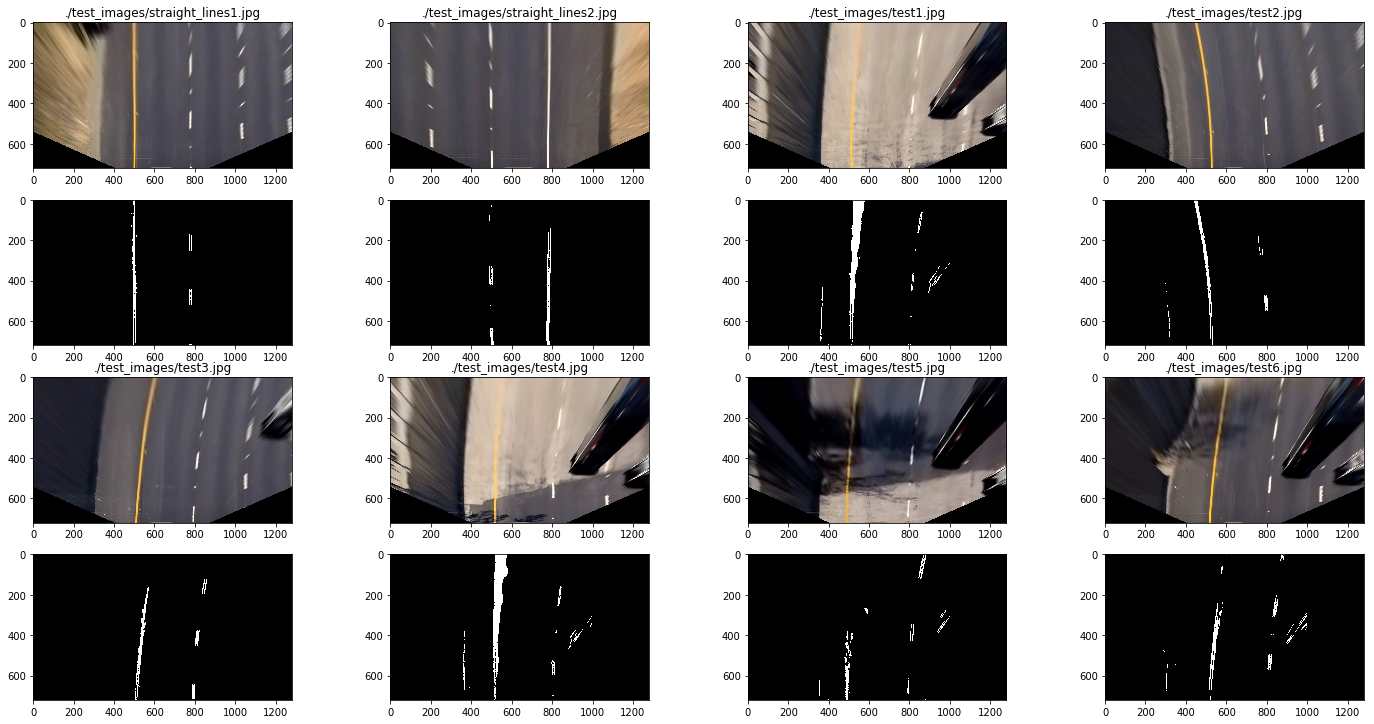

In [287]:
f, subs = plt.subplots(4, 4, figsize=(20,10))
plt.tight_layout()
for idx, fname in enumerate(test_images):
    image = cv2.imread(fname)
    warped = prepare_image(image)
    converted = convert_color(warped)
    
    if 0 <= idx and idx <= 3:
        subWarped = subs[0][idx]
        sub = subs[1][idx]

    else:
        subWarped = subs[2][idx%4]
        sub = subs[3][idx%4]
    subWarped.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    subWarped.set_title(fname)    
    sub.imshow(converted, cmap='gray')

In [222]:
def draw_line_undist(undist, binary_warped, line):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([line.left_fitx, line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([line.right_fitx, line.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int32([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

## Find lane lines

In [309]:
# Class represents detected line.
class Line:
    def __init__(self, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, image_shape):
        self.image_shape = image_shape
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds
        self.left_concat = np.concatenate(left_lane_inds)
        self.right_concat = np.concatenate(right_lane_inds)
        self.leftx = nonzerox[self.left_concat]
        self.lefty = nonzeroy[self.left_concat]
        self.rightx = nonzerox[self.right_concat]
        self.righty = nonzeroy[self.right_concat]
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        self.ploty = np.linspace(0, image_shape[0]-1, image_shape[0])
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

    # Get the x coordinate of left lane on the top of the image.
    def get_top_leftx(self):
        return self.leftx[len(self.leftx)-1]
    # Get the y coordinate of left lane on the top of the image.
    def get_top_rightx(self):
        return self.rightx[len(self.rightx)-1]

    # Get the x coordinate of left lane on the top of the image.
    def get_bottom_leftx(self):
        return self.leftx[0]
    # Get the y coordinate of left lane on the top of the image.
    def get_bottom_rightx(self):
        return self.rightx[0]

    def get_center_deviation(self):
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        return (self.image_shape[0]/2 - (self.rightx[0] + self.leftx[0])/2) * xm_per_pix
    
    def get_curvature(self):
        y_eval = np.max(self.ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(self.lefty*ym_per_pix, self.leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.righty*ym_per_pix, self.rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        return (left_curverad, right_curverad)

In [310]:
class DetectedLines:
    def __init__(self, keep_num=5):
        self.lines = []
        self.keep_num = keep_num

    # insert new detected line.
    def push(self, line):
        if len(self.lines) >= self.keep_num:
            self.lines = self.lines[1:self.keep_num]
        self.lines.append(line)
    # get the latest detected line.
    def get_latest(self):
        if len(self.lines) > 0:
            return self.lines[len(self.lines)-1]
        else:
            return None

In [311]:
def find_lane(binary_warped, last_line=None):

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    if last_line == None:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    else:
        leftx_base = last_line.get_bottom_leftx()
        rightx_base = last_line.get_bottom_rightx()

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 1000
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = (\
                          (nonzeroy >= win_y_low) & \
                          (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) & \
                          (nonzerox < win_xleft_high)\
                         ).nonzero()[0]
        good_right_inds = (\
                           (nonzeroy >= win_y_low) & \
                           (nonzeroy < win_y_high) & \
                           (nonzerox >= win_xright_low) & \
                           (nonzerox < win_xright_high)\
                          ).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    line = Line(left_lane_inds, right_lane_inds, nonzerox, nonzeroy, binary_warped.shape)

    out_img[nonzeroy[line.left_concat], nonzerox[line.left_concat]] = [255, 0, 0]
    out_img[nonzeroy[line.right_concat], nonzerox[line.right_concat]] = [0, 0, 255]

    return (out_img, line)

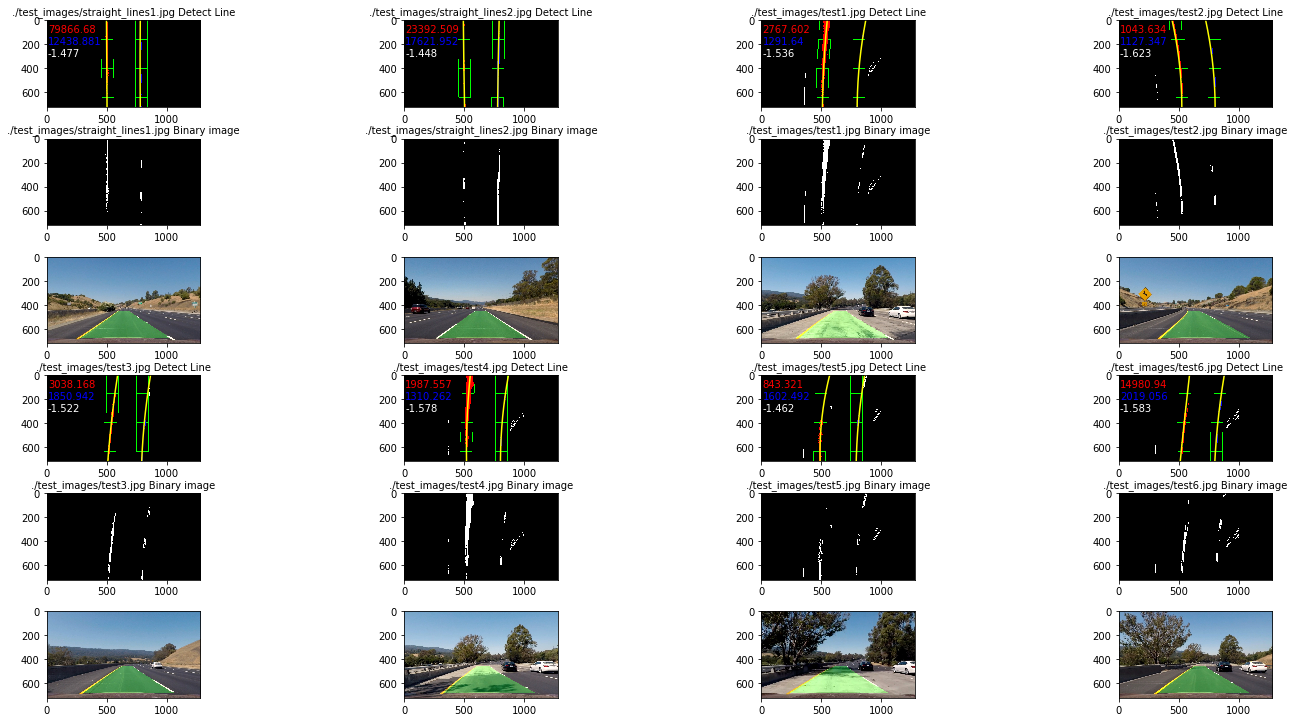

In [312]:
f, subs = plt.subplots(6, 4, figsize=(20,10))
plt.tight_layout()
for idx, fname in enumerate(test_images):
    image = cv2.imread(fname)
    undist = undist_image(image)
    warped = prepare_image(image)
    converted = convert_color(warped)
    params = find_lane(converted)
    out_image = params[0]
    line = params[1]

    curves = line.get_curvature()
    newwarp = draw_line_undist(undist, converted, line)
    if 0 <= idx and idx <= 3:
        sub = subs[0][idx]
        subBin = subs[1][idx]
        subUnwarp = subs[2][idx]
    else:
        sub = subs[3][idx%4]
        subBin = subs[4][idx%4]
        subUnwarp = subs[5][idx%4]

    subBin.imshow(converted, cmap='gray')
    subBin.set_title(fname + " Binary image", fontsize=10)

    sub.imshow(out_image)
    sub.plot(line.left_fitx, line.ploty, color='yellow')
    sub.plot(line.right_fitx, line.ploty, color='yellow')
    sub.set_title(fname + " Detect Line", fontsize=10)
    
    sub.text(10, 100, str(round(curves[0],3)) , color="red")
    sub.text(10, 200, str(round(curves[1],3)) , color="blue")
    dev = line.get_center_deviation()
    sub.text(10, 300, str(round(dev,3)), color="white")
    
    subUnwarp.imshow(cv2.cvtColor(newwarp, cv2.COLOR_BGR2RGB))

## Working with video

In [272]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [277]:
sampling_rate = 15
frames = 0
enable_sampling = False
lines = DetectedLines()
def process_image(image):
    undist = undist_image(image)
    warped = prepare_image(image)
    converted = convert_color(warped)
    global lines
    last_line = lines.get_latest()
    
    try:
        params = find_lane(converted, last_line=last_line)
        out_image = params[0]
        line = params[1]

        lines.push(line)

        curves = line.get_curvature()
        newwarp = draw_line_undist(undist, converted, line)
    except:
        newwarp = undist

    # save image for investigation
    global frames
    frames = frames + 1
    if frames % sampling_rate  == 0 and enable_sampling == True:
        plt.imsave("sampling_images/original" + str(frames) + ".jpg", image)
        plt.imsave("sampling_images/converted" + str(frames) + ".jpg", converted)
        plt.imsave("sampling_images/warped" + str(frames) + ".jpg", warped)
        plt.imsave("sampling_images/newwarp" + str(frames) + ".jpg", newwarp)
    return newwarp

In [278]:
output_video = './output_images/output.mp4'

#clip1 = VideoFileClip("./project_video.mp4").subclip(0,2)
clip1 = VideoFileClip("./project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output_images/output.mp4
[MoviePy] Writing video ./output_images/output.mp4


100%|█████████▉| 1260/1261 [04:55<00:00,  4.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output.mp4 

CPU times: user 4min 23s, sys: 1min 3s, total: 5min 27s
Wall time: 4min 57s


In [279]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))